In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
import os

import matplotlib.pyplot as plt
import random
from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications import VGG19

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

import pandas as pd
import numpy as np

In [ ]:
# {"username":"miguelgallego","key":"6a7a2546d0b0a5683db1abd67fc0380c"}
dataset_link = "https://www.kaggle.com/datasets/harishkumardatalab/food-image-classification-dataset"
od.download(dataset_link)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: miguelgallego
Your Kaggle Key: ··········


100%|██████████| 1.68G/1.68G [00:54<00:00, 33.0MB/s]


In [ ]:
# Ruta de la carpeta principal del conjunto de datos
dataset_dir = "/content/food-image-classification-dataset/Food Classification dataset"

# Lista de carpetas dentro de la carpeta principal
subdirectories = os.listdir(dataset_dir)
print("Contenido de la carpeta principal:")
print(subdirectories)

Contenido de la carpeta principal:
['Hot Dog', 'sushi', 'dal_makhani', 'pizza', 'pav_bhaji', 'omelette', 'burger', 'momos', 'masala_dosa', 'Baked Potato', 'Taco', 'butter_naan', 'chai', 'paani_puri', 'Donut', 'samosa', 'jalebi', 'kulfi', 'fried_rice', 'Fries', 'Sandwich', 'pakode', 'cheesecake', 'chole_bhature', 'Crispy Chicken', 'ice_cream', 'Taquito', 'kadai_paneer', 'idli', 'chicken_curry', 'kaathi_rolls', 'chapati', 'dhokla', 'apple_pie']


In [ ]:
# Lista de clases de alimentos
classes = subdirectories
classes[:3]

['Hot Dog', 'sushi', 'dal_makhani']

In [ ]:
# Directorio raíz del conjunto de datos
dataset_root = "/content/food-image-classification-dataset/Food Classification dataset"

# # Muestra ejemplos de imágenes de cada clase
# num_examples_per_class = 3
# for food_class in classes:
#     class_dir = os.path.join(dataset_root, food_class)
#     image_files = os.listdir(class_dir)
#     random.shuffle(image_files)  # Baraja las imágenes para mostrar ejemplos aleatorios
#     plt.figure(figsize=(12, 4))
#     for i in range(num_examples_per_class):
#         img_path = os.path.join(class_dir, image_files[i])
#         img = Image.open(img_path)
#         plt.subplot(1, num_examples_per_class, i + 1)
#         plt.imshow(img)
#         plt.title(food_class)
#     plt.show()


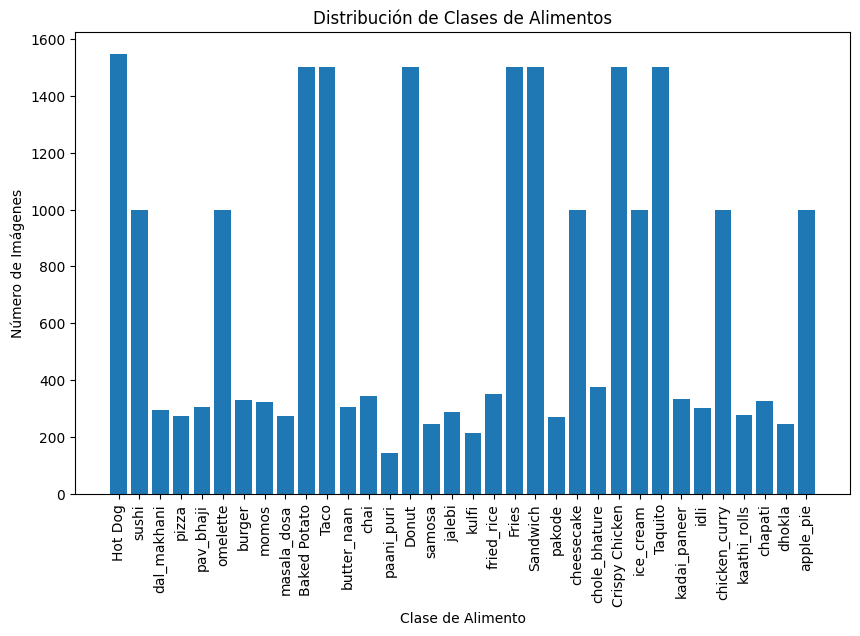


Número total de imágen: 23873


In [ ]:
# Calcula el número de imágenes por clase
num_images_per_class = {food_class: len(os.listdir(os.path.join(dataset_root, food_class))) for food_class in classes}
# print(len(os.listdir(os.path.join(dataset_root, food_class)))for food_class in classes)

# Muestra la distribución de clases
plt.figure(figsize=(10, 6))
plt.bar(num_images_per_class.keys(), num_images_per_class.values())
plt.xlabel('Clase de Alimento')
plt.ylabel('Número de Imágenes')
plt.title('Distribución de Clases de Alimentos')
plt.xticks(rotation=90)
plt.show()

n_images = sum(num_images_per_class.values())
print(f"\nNúmero total de imágen: {n_images}")

In [ ]:
# Calcula el número de imágenes por clase
num_images_per_class = {food_class: len(os.listdir(os.path.join(dataset_root, food_class))) for food_class in classes}
num_images_per_class

{'Hot Dog': 1548,
 'sushi': 1000,
 'dal_makhani': 295,
 'pizza': 275,
 'pav_bhaji': 305,
 'omelette': 1000,
 'burger': 331,
 'momos': 323,
 'masala_dosa': 273,
 'Baked Potato': 1500,
 'Taco': 1500,
 'butter_naan': 307,
 'chai': 344,
 'paani_puri': 144,
 'Donut': 1500,
 'samosa': 244,
 'jalebi': 288,
 'kulfi': 214,
 'fried_rice': 350,
 'Fries': 1500,
 'Sandwich': 1500,
 'pakode': 269,
 'cheesecake': 1000,
 'chole_bhature': 376,
 'Crispy Chicken': 1500,
 'ice_cream': 1000,
 'Taquito': 1500,
 'kadai_paneer': 334,
 'idli': 302,
 'chicken_curry': 1000,
 'kaathi_rolls': 279,
 'chapati': 327,
 'dhokla': 245,
 'apple_pie': 1000}

In [ ]:
# Obtiene las dimensiones de una imagen de muestra
random_class = random.choice(classes)
random_img = random.choice(os.listdir(os.path.join(dataset_root,random_class)))
sample_image_path = os.path.join(dataset_root, random_class, random_img)
sample_image = Image.open(sample_image_path)
image_width, image_height = sample_image.size
print(f"Ancho de imagen: {image_width}px, Alto de imagen: {image_height}px")


Ancho de imagen: 1364px, Alto de imagen: 2048px


In [ ]:
# Redimensionado de las imágenes
target_size = (224, 224)  # Tamaño deseado de las imágenes

def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize(target_size, Image.LANCZOS)  # Redimensionar la imagen
    # Realizar otras transformaciones, como normalización de píxeles, aquí si es necesario?
    return image

In [ ]:
# Inicializa listas para almacenar las rutas de imágenes y etiquetas
image_paths = []
labels = []

# Itera a través de las carpetas de clases de alimentos
for food_class in subdirectories:
    class_dir = os.path.join(dataset_dir, food_class)
    if os.path.isdir(class_dir):
        # Enumera los archivos de imágenes en la carpeta de la clase
        class_image_paths = [os.path.join(class_dir, filename) for filename in os.listdir(class_dir)]
        # Agrega las rutas de imágenes a la lista
        image_paths.extend(class_image_paths)
        # Agrega las etiquetas correspondientes (nombre de la clase) a la lista
        labels.extend([food_class] * len(class_image_paths))

In [ ]:
# %%time

# # Aplicar la función par cambiar el tamaño de las imágnes
# dic_imag_path = {im: preprocess_image(im) for im in image_paths}

In [ ]:
# # Comprobar cómo quedan las imagnes despúes de remodelarlas
# n = random.randint(1, n_images)
# print(f"Label imagen: {labels[n]}")
# image_width, image_height = dic_imag_path[image_paths[n]].size
# print(f"Ancho de imagen: {image_width}px, Alto de imagen: {image_height}px")
# dic_imag_path[image_paths[n]]


In [ ]:
# Crear un DataFrame con las rutas de las imágenes y las etiquetas
data = {'filename': image_paths, 'class': labels}
df = pd.DataFrame(data)
df.groupby('class').count()

,filename
class,
Baked Potato,1500
Crispy Chicken,1500
Donut,1500
Fries,1500
Hot Dog,1548
Sandwich,1500
Taco,1500
Taquito,1500
apple_pie,1000


In [ ]:
class_names = df['class'].unique()

In [ ]:
# Dividir los datos en entrenamiento (70%) y temporales (30%)
train_data, temp_data = train_test_split(df, test_size=0.3, random_state=42)

# Dividir los datos temporales en validación (50%) y prueba (50%)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

In [ ]:
# Crea y define el ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0/255, # Normalizar los valores de píxeles al rango [0, 1]
    # preprocessing_function=tf.image.rgb_to_grayscale
    # rotation_range=20,      # Rango de rotación aleatoria
    # width_shift_range=0.2,  # Desplazamiento horizontal aleatorio
    # height_shift_range=0.2, # Desplazamiento vertical aleatorio
    # shear_range=0.2,        # Distorsión de corte aleatoria
    # zoom_range=0.2,         # Ampliación aleatoria
    # horizontal_flip=True,   # Volteo horizontal aleatorio
    # fill_mode='nearest'     # Estrategia de relleno
)

batch_size = 32

# Crear generadores de datos para entrenamiento, validación y prueba
train_generator = datagen.flow_from_dataframe(
    dataframe = train_data,
    target_size=(224, 224),  # Ajusta el tamaño según tu modelo
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = datagen.flow_from_dataframe(
    dataframe = validation_data,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # No es necesario mezclar los datos de validación
)

test_generator = datagen.flow_from_dataframe(
    dataframe = test_data,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # No es necesario mezclar los datos de prueba
)

images, img_labels = next(train_generator)
print("Forma del lote de imágenes:", images.shape)

Found 16711 validated image filenames belonging to 34 classes.
Found 3581 validated image filenames belonging to 34 classes.
Found 3581 validated image filenames belonging to 34 classes.
Forma del lote de imágenes: (32, 224, 224, 3)


In [ ]:
# # Tomar un lote de imágenes del generador
# images, img_labels = next(train_generator)

# # Verificar las formas de las imágenes en el lote
# print("Forma del lote de imágenes:", images.shape)  # Debería ser (batch_size, height, width, channels)

# # Seleccionar una imagen del lote (por ejemplo, la primera imagen)
# image = images[0]  # Cambia el índice si deseas visualizar otra imagen

# # Mostrar la imagen utilizando Matplotlib
# plt.figure(figsize=(3, 3))
# plt.imshow(image.squeeze())  # Asegúrate de usar 'gray' para imágenes en escala de grises
# plt.axis('off')  # Deshabilita los ejes
# plt.title(f'Clase: {img_labels[0]}')  # Muestra la etiqueta de clase (cambia si no usas one-hot encoding)
# plt.show()


In [ ]:
# # Codificaión de las etiquetas
# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)
# y_test_encoded = label_encoder.transform(y_test)
# # label_encoder.classes_

# print(f'y_train_encoded {len(y_train_encoded)}')
# print(f'y_test_encoded {len(y_test_encoded)}')

In [ ]:
# model = VGG19(weights='imagenet', include_top=False)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

# num_classes = 34  # Reemplaza con el número de clases en tu dataset

# # Agrega una nueva capa de salida
# x = model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)  # Capa oculta opcional
# predictions = Dense(num_classes, activation='softmax')(x)  # Capa de salida

# # Crea un nuevo modelo con la capa de salida modificada
# new_model = Model(inputs=model.input, outputs=predictions)

from keras.layers import Flatten, Dense

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(34, activation='softmax')(x)

# Crea un nuevo modelo con la capa de salida modificada
new_model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
new_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Entrenar el modelo utilizando los generadores de datos
epochs = 10  # Número de épocas
history = new_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,  # Número total de lotes por época
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,  # Número total de lotes de validación por época
)

# model.fit_generator(train_generator, steps_per_epoch=train_generator.samples // batch_size,
#                     validation_data=validation_generator, validation_steps=validation_generator.samples // batch_size,
#                     epochs=epochs)

In [ ]:
new_model.save('second_model_version.h5')
new_model.save('my_second_model.keras')

In [ ]:
from google.colab import files

files.download('second_model_version.h5')
files.download('my_second_model.keras')

In [ ]:
# Cargar el modelo
new_model = load_model('/content/firs_model_version.h5')

In [ ]:
test_loss, test_accuracy = new_model.evaluate(validation_generator)
print(f"Pérdida en el conjunto de prueba: {test_loss}")
print(f"Precisión en el conjunto de prueba: {test_accuracy}")

In [ ]:
from sklearn.metrics import confusion_matrix

# Predicciones del modelo en el conjunto de datos de prueba
predictions = new_model.predict(test_generator)
# Convierte las predicciones en etiquetas de clase (por ejemplo, utilizando np.argmax)
predicted_classes = np.argmax(predictions, axis=1)

# Calcula la matriz de confusión
true_classes = test_generator.classes
confusion = confusion_matrix(true_classes, predicted_classes)
print("Matriz de Confusión:")
print(confusion)


In [ ]:
from sklearn.metrics import classification_report

# Calcula precision, recall y f1-score por clase
report = classification_report(true_classes, predicted_classes, target_names=class_names)
print("Reporte de Clasificación:")
print(report)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [ ]:
len(validation_generator)

In [ ]:
# Obtén las predicciones del modelo en el conjunto de prueba
y_pred = new_model.predict(validation_generator)
print(f'y_pred {len(y_pred)}')

In [ ]:
from keras.utils import to_categorical
print(f'Sin convertir {validation_generator} {len(validation_generator)}')
# Convierte las etiquetas de prueba a formato "one-hot"
y_test_encoded = to_categorical(validation_generator, num_classes=num_classes)
print(f'\nConvertidas a  One-Hot {y_test_encoded} {len(y_test_encoded)}')

In [ ]:
# from keras.utils import to_categorical
# print(f'Sin convertir {y_test_encoded} {len(y_test_encoded)}')
# # Convierte las etiquetas de prueba a formato "one-hot"
# y_test_encoded = to_categorical(y_test_encoded, num_classes=num_classes)
# print(f'\nConvertidas a  One-Hot {y_test_encoded} {len(y_test_encoded)}')

In [ ]:
# Decodifica las etiquetas predichas y verdaderas
print(f'y_pred {len(y_pred)}')
y_pred_decoded = np.argmax(y_pred, axis=1)  # Predicciones
print(f'y_pred_decoded {len(y_pred_decoded)}')
y_true_decoded = np.argmax(y_test_encoded, axis=1)  # Etiquetas verdaderas
print(f'y_true_decoded {len(y_true_decoded)}')


In [ ]:
# y_true_decoded = y_true_decoded[:len(y_pred_decoded)]

In [ ]:
# Calcula la matriz de confusión
confusion = confusion_matrix(y_true_decoded, y_pred_decoded)
print("Matriz de Confusión:")
print(confusion)

In [ ]:
# Genera el informe de clasificación
classification_rep = classification_report(y_true_decoded, y_pred_decoded)
print("Informe de Clasificación:")
print(classification_rep)
